In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("DE_youtube_trending_data.csv", low_memory=False)

In [5]:

print("Total Rows and Columns:", df.shape)
print("\nColumns List:", df.columns.tolist())
print("\nData Table:")
display(df.head())

Total Rows and Columns: (268736, 16)

Columns List: ['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description']

Data Table:


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,KJi2qg5F-9E,Bonez MC - HOLLYWOOD (Snippet),2020-08-11T18:00:03Z,UCGh8tmH9x9njaI2mXfh2fyg,CrhymeTV,10,2020-08-12T00:00:00Z,187|187 Strassenbande|BONEZ MC|RAF Camora|MAXW...,573902,69319,970,3311,https://i.ytimg.com/vi/KJi2qg5F-9E/default.jpg,False,False,Hollywood Fanbox vorbestellen ► http://bonezmc...
1,K0vYnOn7wZI,Nik hat heftige Probleme in Köln! 😱😫 #1925 | K...,2020-08-11T17:00:09Z,UCnrvUg5MJWPDSrv_voT7AqA,Köln 50667,24,2020-08-12T00:00:00Z,Köln|50667|RTL2|RTL|Serie|k50667|ganze folge|t...,381375,13637,435,866,https://i.ytimg.com/vi/K0vYnOn7wZI/default.jpg,False,False,"Toni gerät in Panik, als plötzlich ein Unbekan..."
2,2bbn9b79LRc,Camper Tour 2020 - ROADTRIP durch Österreich |...,2020-08-11T18:00:00Z,UCBt8RY61tvanrhkzeZdNICw,AnaJohnson,24,2020-08-12T00:00:00Z,camper tour|camper tour deutsch|camper tour de...,142296,9480,144,364,https://i.ytimg.com/vi/2bbn9b79LRc/default.jpg,False,False,"Mehr von unserem Trip quer durch Deutschland, ..."
3,Zv-3qNnAMaM,Ich TESTE SHEIN BIKINIS (try on haul) - UNMÖGL...,2020-08-12T09:00:08Z,UCccDoH6QpRCjjcMgl5f88wA,Einfach Marci,24,2020-08-12T00:00:00Z,[None],55640,3420,124,229,https://i.ytimg.com/vi/Zv-3qNnAMaM/default.jpg,False,False,"Heii Cuties,Was soll ich in kommender Zeit noc..."
4,7clgQLneouU,STATEMENT zu meinem BAN! 😒 | Bald vielleicht P...,2020-08-11T12:00:02Z,UC8E8eD7mOcnMazJT4laKbFQ,Domo,24,2020-08-12T00:00:00Z,Papaplatte|papaplatte twitch best of|papaplatt...,233899,25251,375,1051,https://i.ytimg.com/vi/7clgQLneouU/default.jpg,False,False,Domo hier! Abonnieren! Liken! Genießen!\r\rWen...


In [8]:

df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')  # parse timestamps
df = df.dropna(subset=['publishedAt', 'likes', 'comment_count', 'view_count'])  # require key fields

In [10]:

# extract hour of publish and day of week
df['publish_hour'] = df['publishedAt'].dt.hour        # 0-23
df['publish_dayofweek'] = df['publishedAt'].dt.dayofweek  # 0=Mon .. 6=Sun

In [11]:

# create a simple engagement metric (you can change weights)
df['engagement'] = df['likes'] + df['comment_count']   # simple strong signal for engagement

In [12]:

# Keep a subset of useful columns for the simple model
cols_keep = [
    'publish_hour', 'publish_dayofweek', 'view_count', 'likes', 'dislikes',
    'comment_count', 'comments_disabled', 'ratings_disabled', 'category_id',
    'engagement'
]

In [13]:
# Some columns might not exist with exact names in the CSV; drop missing
cols_keep = [c for c in cols_keep if c in df.columns]

data = df[cols_keep].copy()

# Convert boolean-ish columns to numeric if necessary
if 'comments_disabled' in data.columns:
    data['comments_disabled'] = data['comments_disabled'].astype(int)
if 'ratings_disabled' in data.columns:
    data['ratings_disabled'] = data['ratings_disabled'].astype(int)

print("\nPrepared dataset shape:", data.shape)
display(data.head())


Prepared dataset shape: (268736, 9)


,publish_hour,publish_dayofweek,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,engagement
0,18,1,573902,69319,970,3311,0,0,72630
1,17,1,381375,13637,435,866,0,0,14503
2,18,1,142296,9480,144,364,0,0,9844
3,9,2,55640,3420,124,229,0,0,3649
4,12,1,233899,25251,375,1051,0,0,26302



Average engagement per publish hour (mean):


,publish_hour,engagement
0,0,245956.377857
1,1,213729.062760
2,2,169197.425738
3,3,405660.540354
4,4,441504.325299
5,5,234207.239879
6,6,87348.979749
7,7,54875.633462
8,8,64762.430112
9,9,103781.915660


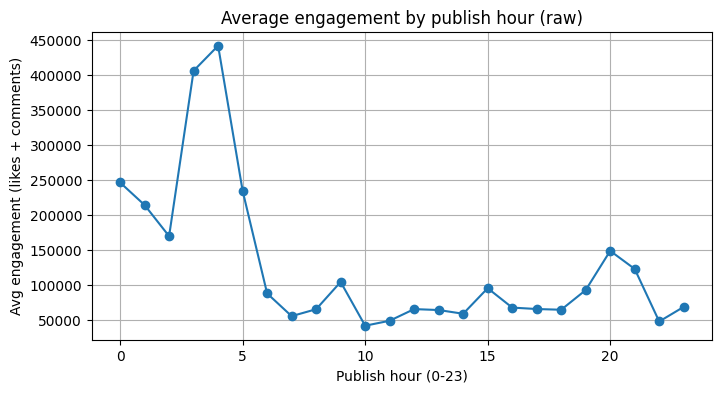

In [14]:

# --------------------------
# 5) Quick exploratory aggregation (which hours look good on average?)
# --------------------------
hour_avgs = data.groupby('publish_hour')['engagement'].mean().reset_index()
print("\nAverage engagement per publish hour (mean):")
display(hour_avgs.sort_values('publish_hour').reset_index(drop=True))

plt.figure(figsize=(8,4))
plt.plot(hour_avgs['publish_hour'], hour_avgs['engagement'], marker='o')
plt.xlabel("Publish hour (0-23)")
plt.ylabel("Avg engagement (likes + comments)")
plt.title("Average engagement by publish hour (raw)")
plt.grid(True)
plt.show()

In [15]:

features = [c for c in data.columns if c not in ['engagement', 'publish_hour']]  # we'll include publish_hour too later

In [16]:

# one-hot encode category_id if present
if 'category_id' in data.columns:
    data = pd.get_dummies(data, columns=['category_id'], prefix='cat')

In [17]:

# final feature columns
X_cols = [c for c in data.columns if c != 'engagement']
X = data[X_cols]
y = data['engagement'].values

In [18]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:

# --------------------------
# 7) Train a Random Forest regressor
# --------------------------
model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

,n_estimators,150
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"\nModel evaluation: MSE={mse:.2f}, RMSE={rmse:.2f}, R^2={r2:.3f}")


Model evaluation: MSE=71847317.74, RMSE=8476.28, R^2=1.000


In [24]:

# Feature importances (top 12)
importances= pd.Series(model.feature_importances_, index=X_cols).sort_values(ascending=False)
display(importances.head(12))

likes                9.841754e-01
comment_count        1.488632e-02
view_count           5.429454e-04
dislikes             1.960111e-04
publish_hour         1.278538e-04
publish_dayofweek    7.145674e-05
comments_disabled    1.929343e-09
ratings_disabled     5.460982e-10
dtype: float64

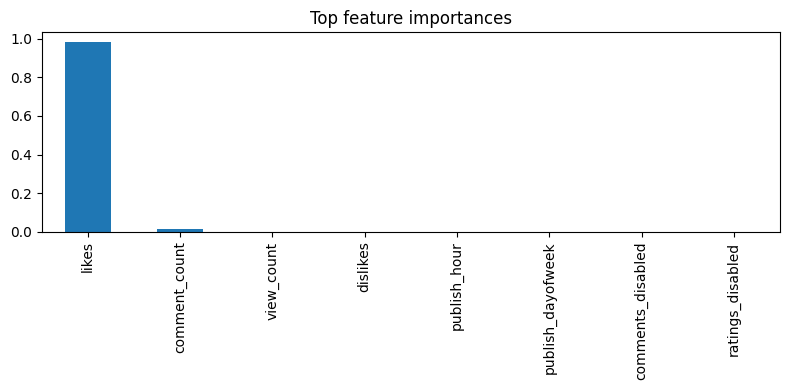

In [25]:

plt.figure(figsize=(8,4))
importances.head(12).plot(kind='bar')
plt.title("Top feature importances")
plt.tight_layout()
plt.show()

In [26]:

# --------------------------
# 8) Recommendation function: try all 24 hours for a draft video
# --------------------------
def recommend_best_hours(model, base_features, X_columns, top_k=3):

    rows = []
    for hour in range(24):
        row = base_features.copy()
        row['publish_hour'] = hour
        # Build DataFrame with all required columns; missing columns -> 0
        r = {c: row.get(c, 0) for c in X_columns}
        df_row = pd.DataFrame([r], columns=X_columns)
        pred = model.predict(df_row)[0]
        rows.append((hour, pred))
    rows_sorted = sorted(rows, key=lambda x: x[1], reverse=True)
    return rows_sorted[:top_k], pd.DataFrame(rows, columns=['hour','predicted_engagement'])

In [27]:

# Example: prepare a draft video base features
# Use typical values, or derive from an existing account's averages
# IMPORTANT: include the same one-hot encoded category columns if they exist
example_base = {
    'publish_dayofweek': 2,   # Wednesday
    'views': 10000,           # expected initial view potential (you may set to 0)
    'likes': 0,               # before publishing it's 0
    'dislikes': 0,
    'comment_count': 0,
    'comments_disabled': 0,
    'ratings_disabled': 0
}

In [28]:

# If your model used category one-hot features (cat_{id}) include the desired category=1 and others 0
for col in X.columns:
    if col.startswith('cat_') and col not in example_base:
        example_base[col] = 0
# set the category you'd like (for example, if cat_10 exists)
# example_base['cat_10'] = 1   # uncomment and set to the correct category id column name

In [29]:

# Now get recommendations
top_k, all_preds = recommend_best_hours(model, example_base, X.columns, top_k=5)
print("\nTop recommended hours (hour, predicted engagement):")
for h, p in top_k:
    print(f" - Hour {h}: predicted engagement ≈ {p:.1f}")


Top recommended hours (hour, predicted engagement):
 - Hour 10: predicted engagement ≈ 3.9
 - Hour 11: predicted engagement ≈ 3.9
 - Hour 12: predicted engagement ≈ 3.9
 - Hour 13: predicted engagement ≈ 3.8
 - Hour 14: predicted engagement ≈ 3.8


In [30]:

# Show all hours sorted by hour for clarity
display(all_preds.sort_values('hour').reset_index(drop=True))

,hour,predicted_engagement
0,0,3.560000
1,1,3.560000
2,2,3.560000
3,3,3.560000
4,4,3.560000
5,5,3.560000
6,6,3.560000
7,7,3.560000
8,8,3.560000
9,9,3.560000
